In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV  # Bayesian Optimization
from skopt.space import Real, Integer, Categorical # Import Categorical from skopt.space
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.impute import SimpleImputer



In [38]:
df = pd.read_csv("ml_salary_dataset_1000 (1).csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Experience (years)        2001 non-null   object
 1   Years at Current Company  2001 non-null   object
 2   Location                  2001 non-null   object
 3   Remote Ratio              2001 non-null   object
 4   Education Level           2001 non-null   object
 5   Company Size              2001 non-null   object
 6   Company Tier              2001 non-null   object
 7   Salary                    2001 non-null   object
 8   Salary (USD)              2001 non-null   object
dtypes: object(9)
memory usage: 140.8+ KB
None
  Experience (years) Years at Current Company       Location Remote Ratio  \
0                5.3                      7.3         London          100   
1                1.1                      9.2      Bangalore           50   
2                5.6  

Experience (years)          0
Years at Current Company    0
Location                    0
Remote Ratio                0
Education Level             0
Company Size                0
Company Tier                0
Salary                      0
Salary (USD)                0
dtype: int64


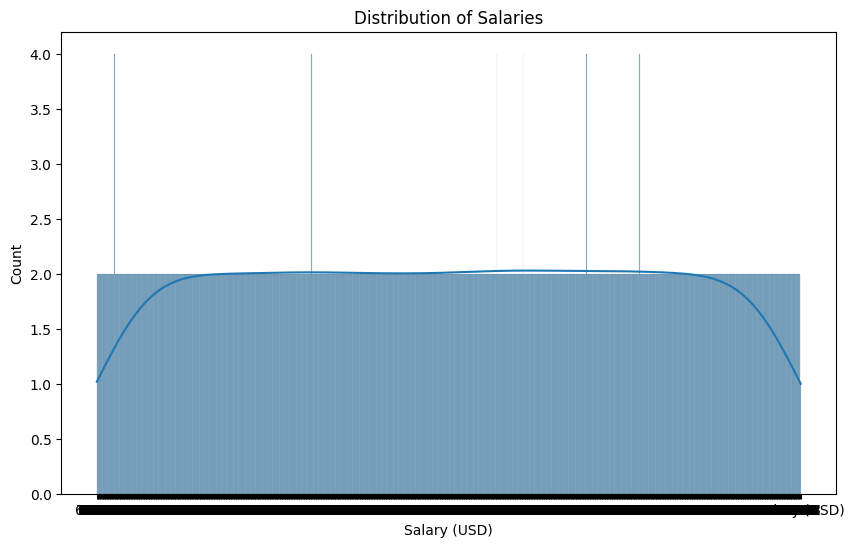

In [39]:
print(df.isnull().sum())

# Additional EDA
plt.figure(figsize=(10, 6))
sns.histplot(df["Salary (USD)"], kde=True, bins=30)
plt.title("Distribution of Salaries")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()


<Figure size 800x600 with 0 Axes>

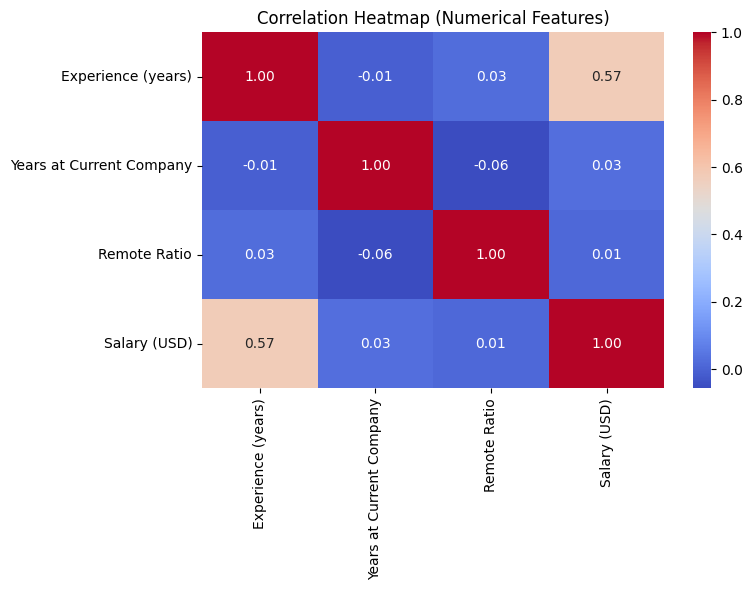

In [40]:
# 📊 Correlation Heatmap (for numerical features only)
plt.figure(figsize=(8, 6))
numeric_cols = ["Experience (years)", "Years at Current Company", "Remote Ratio", "Salary (USD)"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()


In [41]:
# Drop rows where 'Salary (USD)' is missing
df = df.dropna(subset=["Salary (USD)"])

# Now define X and y
X = df.drop(columns=["Salary", "Salary (USD)"])
y = df["Salary (USD)"]


# Define feature sets
numeric_features = ["Experience (years)", "Years at Current Company", "Remote Ratio"]
categorical_features = ["Location", "Education Level", "Company Size", "Company Tier"]

# Numeric pipeline: Impute missing values, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),   # handles NaNs
    ("scaler", StandardScaler())
])

# Categorical pipeline: Impute missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # handles NaNs
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


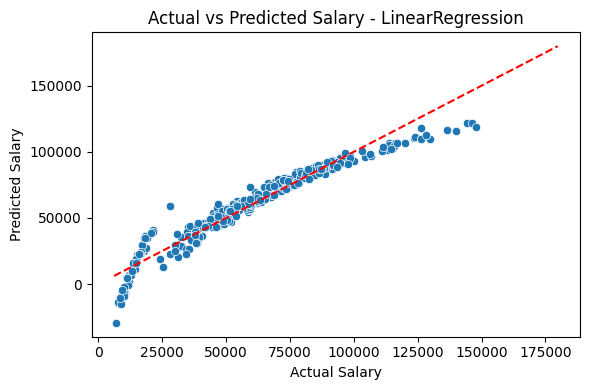

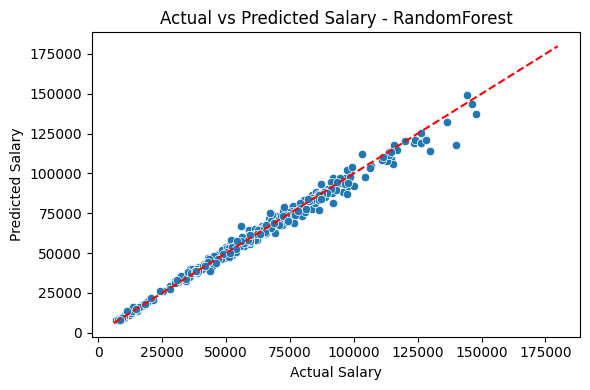

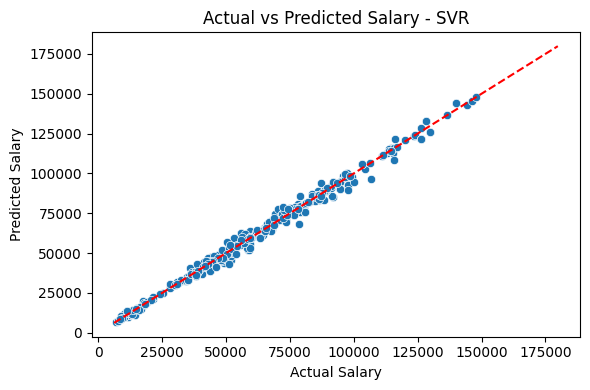

In [43]:
param_grids = {
    "RandomForest": {
        "model__n_estimators": Integer(100, 500),
        "model__max_depth": Integer(10, 50)
    },
    "SVR": {
        "model__kernel": ["rbf", "linear"],
        "model__C": Real(1e-6, 1e+6, "log-uniform"),
        "model__gamma": ["scale", "auto"]
    },
}

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "SVR": SVR()
}

results = {}
best_score = -np.inf
best_model_name = None
best_model_final = None

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    if name in param_grids:
        # Using BayesSearchCV for Bayesian Optimization
        bayes_search = BayesSearchCV(
    pipeline,
    search_spaces=param_grids[name], # Change 'param_space' to 'search_spaces'
    n_iter=50,  # Number of iterations for optimization
    cv=3,
    n_jobs=-1,
    scoring='r2'
)
        bayes_search.fit(X_train, y_train)
        best_model = bayes_search.best_estimator_
    else:
        best_model = pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "MAE": mae, "R2": r2}

    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_model_final = best_model

    # Plot Actual vs Predicted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.title(f"Actual vs Predicted Salary - {name}")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.tight_layout()
    plt.show()


In [44]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)
print()



Model Performance Metrics:
                           MSE          MAE        R2
LinearRegression  6.097794e+07  5510.982762  0.931006
RandomForest      1.320732e+07  2371.895302  0.985057
SVR               6.489336e+06  1589.807288  0.992658



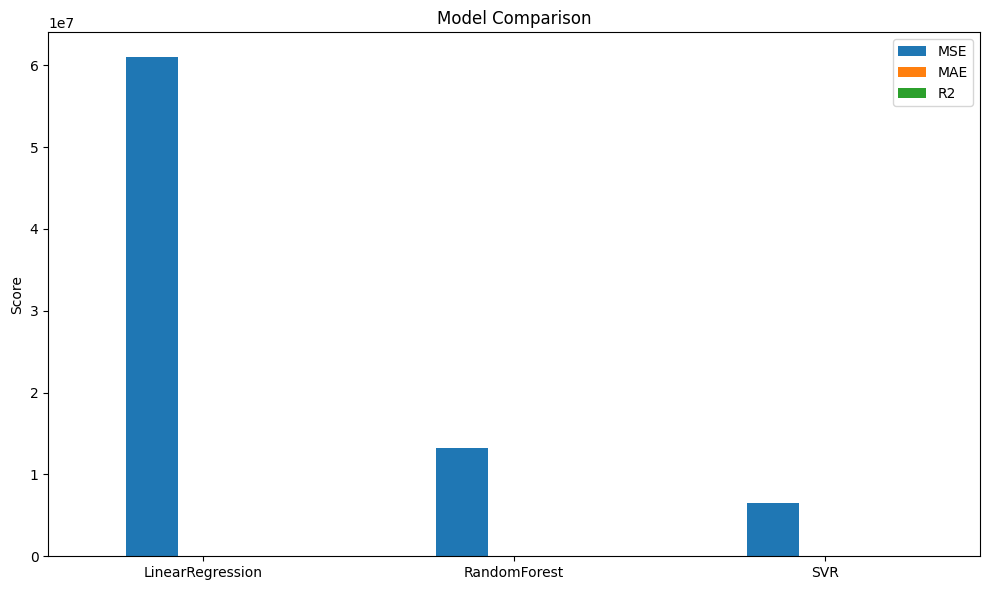

In [45]:
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [46]:
print(f"\nBest Performing Model: {best_model_name}")


Best Performing Model: SVR



Overfitting Check:
Training R² Score: 0.9968
Testing  R² Score: 0.9927
Difference (Train - Test): 0.0042
✅ Model is likely generalizing well.


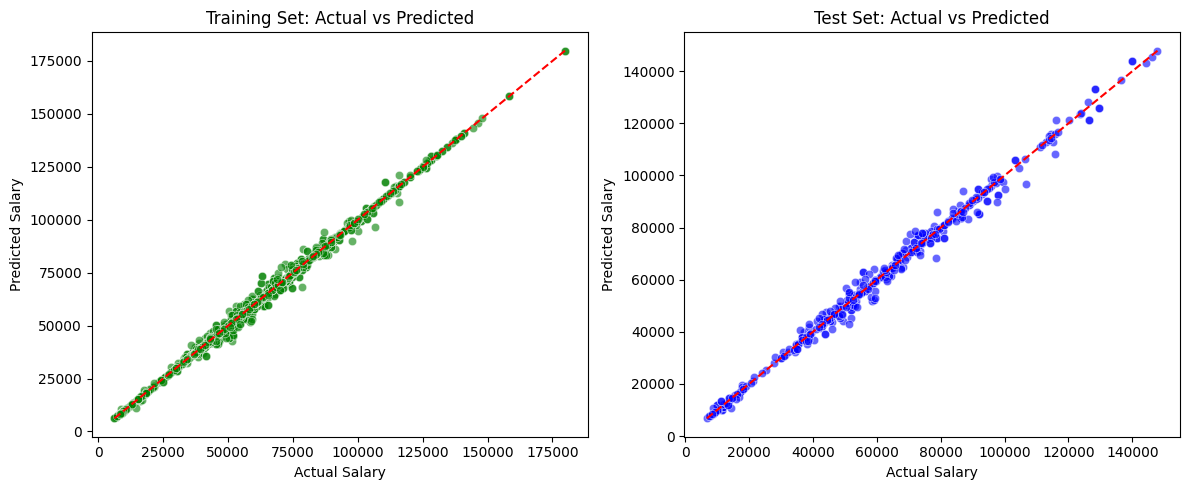

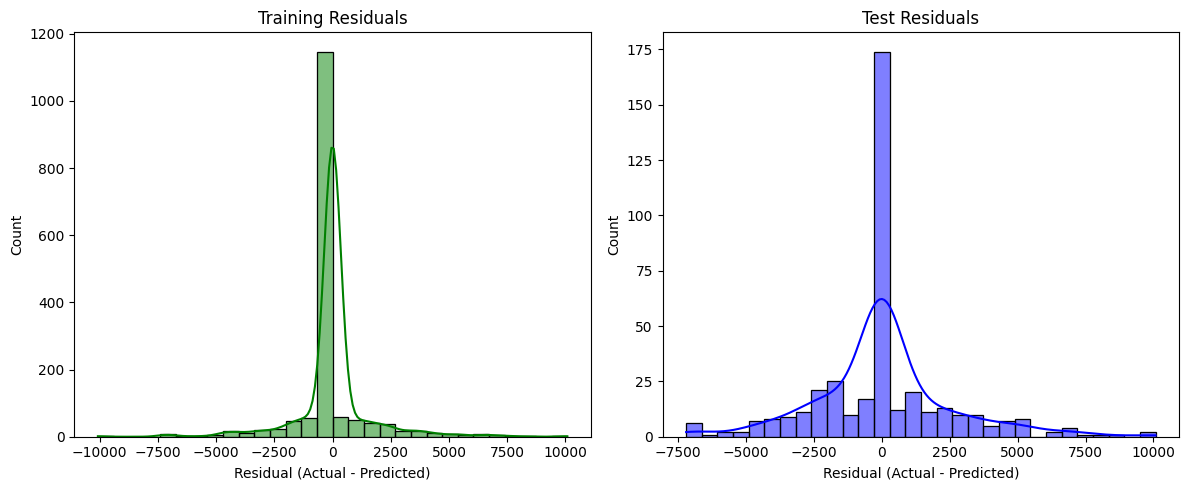

In [47]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred = best_model_final.predict(X_train)
y_test_pred = best_model_final.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nOverfitting Check:")
print(f"Training R² Score: {r2_train:.4f}")
print(f"Testing  R² Score: {r2_test:.4f}")
print(f"Difference (Train - Test): {r2_train - r2_test:.4f}")

if (r2_train - r2_test) > 0.1:
    print("⚠️ Potential Overfitting Detected.")
else:
    print("✅ Model is likely generalizing well.")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred, color='green', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.tight_layout()
plt.show()

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, bins=30, kde=True, color='green')
plt.title("Training Residuals")
plt.xlabel("Residual (Actual - Predicted)")

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='blue')
plt.title("Test Residuals")
plt.xlabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()


Cross-Validation Evaluation of Best Model:
Cross-Validation R² Scores: [0.99288912 0.99308211 0.99495494 0.99238162 0.99480187]
Average CV R²: 0.9936
Standard Deviation: 0.0011


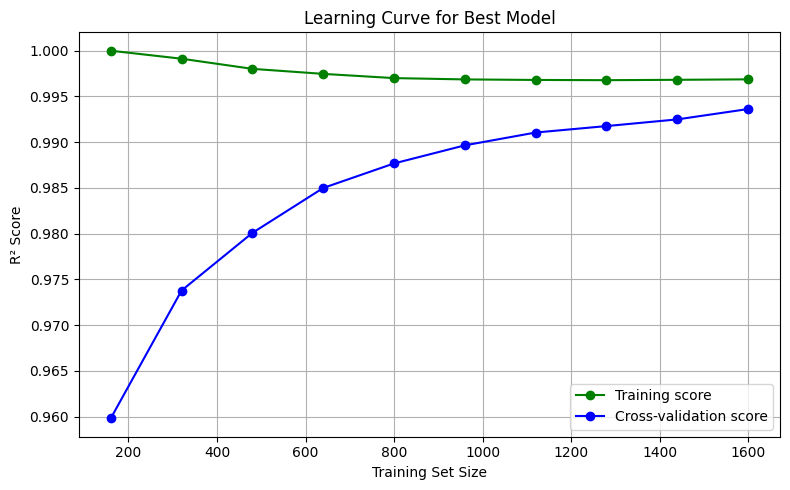

In [48]:
# Cross-Validation Scores for the Best Model
print("\nCross-Validation Evaluation of Best Model:")
cv_scores = cross_val_score(best_model_final, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Plotting the Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model_final, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="green")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="blue")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve for Best Model")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/5k/6w749ccs1xl6drjghr4mlxsw0000gn/T/ipykernel_38880/3662900021.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


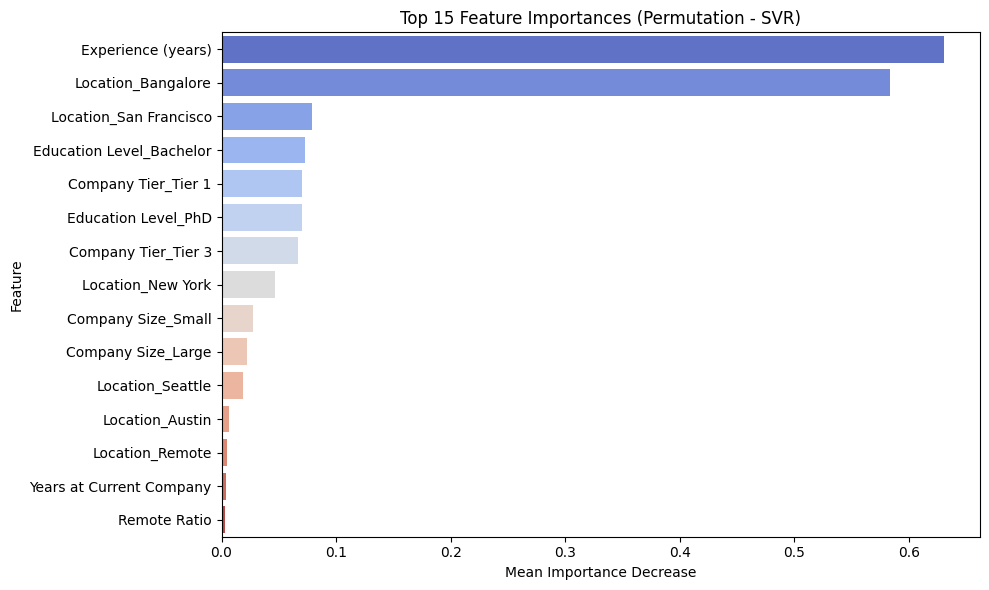

In [49]:
from sklearn.inspection import permutation_importance

# Only proceed if best model was SVR
if best_model_name == "SVR":
    # Step 1: Transform X_test with the preprocessor (used inside the pipeline)
    X_test_transformed = preprocessor.transform(X_test)

    # Step 2: Access the trained SVR model from the pipeline
    svr_model = best_model_final.named_steps["model"]

    # Step 3: Compute permutation importance
    result = permutation_importance(
        svr_model,                      # Only the SVR model
        X_test_transformed,            # Transformed X_test
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    # Step 4: Get final feature names (numeric + one-hot encoded categorical)
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_feature_names)

    # Step 5: Create DataFrame with importance scores
    importances_df = pd.DataFrame({
        "Feature": all_features,
        "Importance Mean": result.importances_mean,
        "Importance Std": result.importances_std
    }).sort_values(by="Importance Mean", ascending=False)

    # Step 6: Plot top 15 important features
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importances_df.head(15),
        x="Importance Mean",
        y="Feature",
        palette="coolwarm"
    )
    plt.title("Top 15 Feature Importances (Permutation - SVR)")
    plt.xlabel("Mean Importance Decrease")
    plt.tight_layout()
    plt.show()


In [50]:
print("\nPlease enter the details for salary prediction:")

experience = float(input("Experience (years): "))
years_at_current_company = float(input("Years at Current Company: "))
location = input("Location (e.g., San Francisco, New York, etc.): ")
remote_ratio = float(input("Remote Ratio (percentage): "))
education_level = input("Education Level (e.g., Bachelor's, Master's, PhD): ")
company_size = input("Company Size (e.g., Small, Medium, Large): ")
company_tier = input("Company Tier (e.g., Tier 1, Tier 2, Tier 3): ")

# Create a DataFrame for the user input
user_input = pd.DataFrame([{
    "Experience (years)": experience,
    "Years at Current Company": years_at_current_company,
    "Location": location,
    "Remote Ratio": remote_ratio,
    "Education Level": education_level,
    "Company Size": company_size,
    "Company Tier": company_tier
}])

# Predict salary using the best model
user_salary_prediction = best_model_final.predict(user_input)

print(f"\nPredicted Salary for the given input: ${user_salary_prediction[0]:,.2f}")



Please enter the details for salary prediction:

Predicted Salary for the given input: $110,296.62
